In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.tree import export_graphviz
from IPython.display import Image

import time
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv('data/final_df.csv')

In [10]:
df = df.iloc[:,1:]

In [11]:
y = df.churn
X = df.drop('churn', axis = 1)

In [12]:
mm = MinMaxScaler()
scaled_df = pd.DataFrame(mm.fit_transform(X), columns = X.columns)
scaled_df.head()

,seniorcitizen,tenure,monthlycharges,totalcharges,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,...,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0.0,0.013889,0.115423,0.003437,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.472222,0.385075,0.217564,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.027778,0.354229,0.012453,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.625000,0.239303,0.211951,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.027778,0.521891,0.017462,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 33)

# Decision Tree Classifier (default)

In [14]:
clf1 = DecisionTreeClassifier(random_state = 33)
clf1.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=33, splitter='best')

In [15]:
test_preds1 = clf1.predict(X_test)
clf1.score(X_test, test_preds1)

1.0

In [16]:
# Calculate and print all four major metrics
print(f"Precision Score: {precision_score(y_test, test_preds1)}")
print(f"Recall Score: {recall_score(y_test, test_preds1)}")
print(f"Accuracy Score: {accuracy_score(y_test, test_preds1)}")
print(f"F1 Score: {f1_score(y_test, test_preds1)}")

Precision Score: 0.4922048997772829
Recall Score: 0.46041666666666664
Accuracy Score: 0.7234525837592277
F1 Score: 0.47578040904198066


AUC Score: 0.6412153590944575


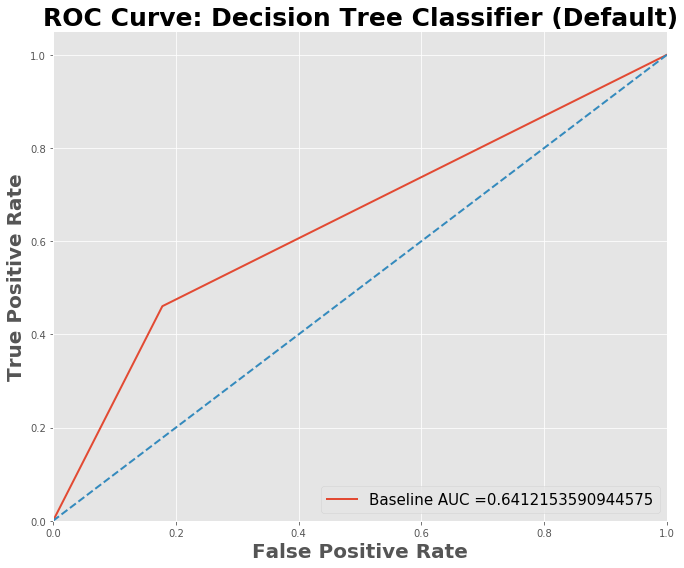

In [17]:
fpr, tpr, threshold = roc_curve(y_test, test_preds1)
# Calculate AUC score from sklearn.metrics library
roc_auc = auc(fpr, tpr)
# Print auc score
print(f'AUC Score: {roc_auc}')

# Plot AUC curve
plt.style.use('ggplot')
plt.figure(figsize = (10,8))
plt.plot(fpr, tpr, lw = 2, label = 'Baseline AUC ='+str(roc_auc))
plt.plot([0,1],[0,1], linestyle = '--', lw = 2)
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.xlabel('False Positive Rate', fontsize = 20, fontweight = 'bold')
plt.ylabel('True Positive Rate', fontsize = 20, fontweight = 'bold')
plt.title('ROC Curve: Decision Tree Classifier (Default)', fontsize = 25, fontweight = 'bold')
plt.legend(loc = 4, fontsize = 15)
plt.tight_layout()

In [18]:
pd.crosstab(y_test, test_preds1, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,1053,228,1281
1,259,221,480
All,1312,449,1761


# `Decision Tree Classifier (GridSearchCV)

In [49]:
clf2 = DecisionTreeClassifier(random_state = 33)
clf_cv_score = cross_val_score(clf2, X_train, y_train, cv = 4)
mean_clf_cv_score = np.mean(clf_cv_score)
print(f"Mean CV SCore: {mean_clf_cv_score :.2%}")

Mean CV SCore: 73.95%


In [72]:
clf3 = DecisionTreeClassifier(random_state = 33)
param_grid = {
    'criterion':['gini','entropy'],
    'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'min_samples_split':[20, 25, 30, 35, 40],
    'min_samples_leaf':[1,2,3,4,5,6]
}
gs_tree = GridSearchCV(clf3, param_grid, cv = 4, verbose = True)
gs_tree.fit(X_train, y_train)

Fitting 4 folds for each of 720 candidates, totalling 2880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 30}


[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed:  1.1min finished


In [74]:
print(f"Best Parameters: {gs_tree.best_params_}")
print(f"Best Score: {gs_tree.best_score_}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 30}
Best Score: 0.7942067398712609


In [79]:
final_clf = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = 6,
    min_samples_leaf = 1,
    min_samples_split = 30,
    random_state = 33)
final_clf.fit(X_train, y_train)
test_preds2 = final_clf.predict(X_test)